# Prepare Files

In [2]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1ZZ_xgbVMEVuX6NxvpFIk8fWwl5rrvKh0'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.tar.gz')

id = '1cLKpcZS-P9TCLO0X1xw2p5ZLIwPuzErM'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.tar.gz')

id = '11opV9N2wI4rcpv5QcsNY2clVgN-IWA7_'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.txt')

id = '1JcC-B4MDgW52YW-OYdK4s-xrM6rKfI54'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('densenet121_epoch_12_val_loss_0.1205.h5')

     |████████████████████████████████| 993kB 4.8MB/s 


In [0]:
# Unzip tar.gz

import tarfile

def un_tar(file_name):
       # untar zip file"""
    tar = tarfile.open(file_name)
    names = tar.getnames()
    tar.extractall()
    tar.close()
    
un_tar('test.tar.gz')
un_tar("train.tar.gz")

In [5]:
# Check the image loaded

import os
train_path = "train2014"
test_path = "val2014"

print(len(os.listdir("train2014")))
print(len(os.listdir("val2014")))

31925
15516


# Data Pre-processing

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
# Label processing

import pandas as pd 
from pandas.core.frame import DataFrame
data = pd.read_table('train.txt',sep='\t',header=None)    

img_list_raw = data[0].tolist()
img_list = []
for i in img_list_raw:
    img_list.append(train_path + '/' + i)

label_list_raw = data[1].tolist()
label_list = []

def process_label(label_str):
    label_int = []
    for x in label_str.split(','):
        label_int.append((int(x)))
    return label_int

for ll in label_list_raw:
    label_list.append(process_label(ll))

dic =  {"filename": img_list, "label": label_list}
df = DataFrame(dic)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


In [9]:
print(df[:10])

          filename     label
0  train2014/0.jpg  [13, 18]
1  train2014/1.jpg      [19]
2  train2014/2.jpg      [10]
3  train2014/3.jpg       [2]
4  train2014/4.jpg    [8, 7]
5  train2014/5.jpg      [19]
6  train2014/6.jpg       [0]
7  train2014/7.jpg      [19]
8  train2014/8.jpg  [18, 19]
9  train2014/9.jpg       [8]


In [10]:
# Image pre-processing and generators

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    preprocessing_function=preprocess_input,
                                    rescale=1. / 255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1
                                   )

val_datagen = ImageDataGenerator(horizontal_flip=True,                                 
                                    preprocessing_function=preprocess_input,
                                    rescale=1. / 255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1
                                  )

test_datagen = ImageDataGenerator(horizontal_flip=True,                                 
                                    preprocessing_function=preprocess_input,
                                    rescale=1. / 255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe = df[: 27000],
                                                     x_col='filename', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                     class_mode='categorical', 
                                                     batch_size=BATCH_SIZE,
                                                     seed=42,
                                                     shuffle=True)

val_generator = val_datagen.flow_from_dataframe(dataframe = df[27000: 30000],
                                                     x_col='filename', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                     class_mode='categorical', 
                                                     batch_size=BATCH_SIZE,
                                                     seed=42,
                                                     shuffle=True)

test_generator = test_datagen.flow_from_dataframe(dataframe = df[30000: ],
                                                     x_col='filename', target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                     class_mode=None,
                                                     batch_size=1,
                                                     seed=42,
                                                     shuffle=False)
num_classes = len(train_generator.class_indices)
print(num_classes)

Found 27000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 1925 images.
20


# Build, Train, Test

In [2]:
# Build model

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=20)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(512,kernel_regularizer=regularizers.l2(l=0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer=regularizers.l2(l=0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.5)(x)
predictions = Dense(20, activation='sigmoid')(x)

    
custom_model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = False

custom_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________

In [0]:
# Compile the model and Callback functions 

custom_model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [10]:
# Train the model

STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size
STEP_SIZE_VALID=val_generator.n // val_generator.batch_size
model_history = custom_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=12,
                    callbacks=callbacks_list
                    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
844/844 [==============================] - 800s 948ms/step - loss: 0.9284 - acc: 0.8840 - val_loss: 0.6108 - val_acc: 0.9438
Epoch 2/12
844/844 [==============================] - 778s 922ms/step - loss: 0.4913 - acc: 0.9474 - val_loss: 0.3789 - val_acc: 0.9557
Epoch 3/12
844/844 [==============================] - 778s 921ms/step - loss: 0.3254 - acc: 0.9537 - val_loss: 0.2642 - val_acc: 0.9578
Epoch 4/12
844/844 [==============================] - 778s 921ms/step - loss: 0.2377 - acc: 0.9574 - val_loss: 0.2047 - val_acc: 0.9597
Epoch 5/12
844/844 [==============================] - 777s 920ms/step - loss: 0.1877 - acc: 0.9599 - val_loss: 0.1771 - val_acc: 0.9606
Epoch 6/12
844/844 [==============================] - 776s 920ms/step - loss: 0.1576 - acc: 0.9623 - val_loss: 0.1666 - val_acc: 0.9581
Epoch 7/12
844/844 [==============================] - 777s 920ms/step - loss: 0.1376 - acc: 0.9642 - val_loss: 0.1418 - val_acc: 0.9608


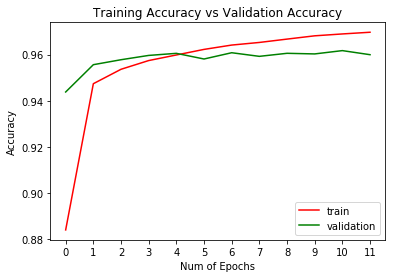

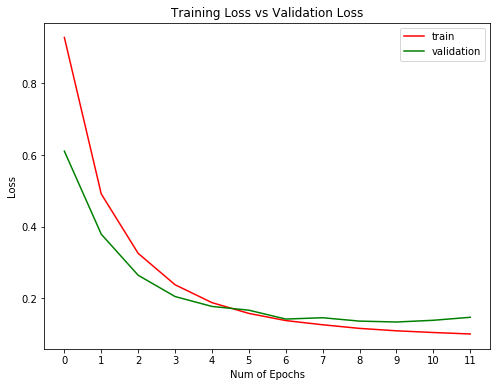

In [12]:
# Accuracy and loss plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 12, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 12, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [36]:
custom_model.evaluate_generator(generator=val_generator,
steps=STEP_SIZE_VALID)

[0.12054033846931254, 0.96418333]

In [0]:
# Save the model
custom_model.save('densenet121_epoch_12_val_loss_0.1205.h5')
custom_model.save_weights('densenet121_epoch:12_val_loss_0.1205_weights.h5')

In [11]:
# Prediction for testing set
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size
test_generator.reset()
pred=custom_model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

1925/1925 [==============================] - 64s 33ms/step


In [64]:
# Evaluate the accuracy on test set
pred_bool = (pred >0.3)

one_predictions = []

predictions=[]
labels = train_generator.class_indices
# print(labels)
labels = dict((v,k) for k,v in labels.items())

################
# Top1 Accuracy    #
################

for i in range(len(pred)):
    imax = np.argmax(pred[i])
    pred_bool[i][imax] = True    

for row in pred:
    a = np.argmax(row)
    one_predictions.append(labels[a])
    
c = 0
test_labels = label_list[30000:]
for i in range(len(test_labels)):
    if one_predictions[i] in test_labels[i]:
        c += 1
print(c/len(test_labels))

filenames=test_generator.filenames
top1_results=pd.DataFrame({"Filename":filenames,
                      "Predictions":one_predictions})
print(top1_results[ :10])

################
# Custom Accuracy    #
################

y_pred_raw = []

for row in pred_bool:
    l=[]
    i = []
    for index,cls in enumerate(row):
        if cls:
            l.append(str(labels[index]))
            i.append(labels[index])
    predictions.append(",".join(l))
    y_pred_raw.append(i)
    
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)
print(results[ :10])

0.7516883116883117
              Filename  Predictions
0  train2014/30000.jpg           19
1  train2014/30001.jpg            2
2  train2014/30002.jpg           18
3  train2014/30003.jpg            2
4  train2014/30004.jpg           16
5  train2014/30005.jpg           14
6  train2014/30006.jpg           18
7  train2014/30007.jpg           19
8  train2014/30008.jpg            6
9  train2014/30009.jpg           17
              Filename Predictions
0  train2014/30000.jpg          19
1  train2014/30001.jpg           2
2  train2014/30002.jpg       18,19
3  train2014/30003.jpg           2
4  train2014/30004.jpg      8,9,16
5  train2014/30005.jpg          14
6  train2014/30006.jpg          18
7  train2014/30007.jpg        9,19
8  train2014/30008.jpg           6
9  train2014/30009.jpg          17


In [63]:
# confusion matrix
mlb = MultiLabelBinarizer(classes=range(20))
y_true = mlb.fit_transform(test_labels)
y_pred = mlb.fit_transform(y_pred_raw)
target = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

multilabel_confusion_matrix(y_true, y_pred)

array([[[1795,   27],
        [  18,   85]],

       [[1858,    6],
        [   4,   57]],

       [[1760,   17],
        [  22,  126]],

       [[1814,   12],
        [   7,   92]],

       [[1762,   26],
        [  22,  115]],

       [[1897,    4],
        [   9,   15]],

       [[1603,  103],
        [  88,  131]],

       [[1698,  108],
        [  50,   69]],

       [[1680,  115],
        [  37,   93]],

       [[1526,  142],
        [  70,  187]],

       [[1874,   11],
        [  22,   18]],

       [[1734,   32],
        [  37,  122]],

       [[1790,   33],
        [  34,   68]],

       [[1834,   15],
        [  16,   60]],

       [[1826,   18],
        [  20,   61]],

       [[1917,    0],
        [   8,    0]],

       [[1766,   41],
        [  24,   94]],

       [[1780,   29],
        [  43,   73]],

       [[1733,   26],
        [  57,  109]],

       [[1527,  166],
        [  85,  147]]])

In [61]:
# classification report
print(classification_report(y_true, y_pred, labels=range(20)))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       103
           1       0.90      0.93      0.92        61
           2       0.88      0.85      0.87       148
           3       0.88      0.93      0.91        99
           4       0.82      0.84      0.83       137
           5       0.79      0.62      0.70        24
           6       0.56      0.60      0.58       219
           7       0.39      0.58      0.47       119
           8       0.45      0.72      0.55       130
           9       0.57      0.73      0.64       257
          10       0.62      0.45      0.52        40
          11       0.79      0.77      0.78       159
          12       0.67      0.67      0.67       102
          13       0.80      0.79      0.79        76
          14       0.77      0.75      0.76        81
          15       0.00      0.00      0.00         8
          16       0.70      0.80      0.74       118
          17       0.72    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Output

In [8]:
# Load model
custom_model = load_model('densenet121_epoch_12_val_loss_0.1205.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
# Linux: Create a  folder to contain val images.
!mkdir output

In [0]:
# Linux: Move the images folder into new folder.
!cp -r ./val2014 ./output

In [15]:
# Prepare prediction.
pred_generator = test_datagen.flow_from_directory(
                            directory=r"./output",
                            target_size=(224, 224),
                            color_mode="rgb",
                            batch_size=1,
                            class_mode=None,
                            shuffle=False,
                            seed=42
                        )

Found 15516 images belonging to 1 classes.


In [16]:
# Prediction for giving test set
STEP_SIZE_PRED = pred_generator.n//pred_generator.batch_size

pred_generator.reset()
pred = custom_model.predict_generator(pred_generator,
                steps=STEP_SIZE_PRED,
                verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

15516/15516 [==============================] - 768s 49ms/step


In [37]:
# Get the label and write into txt file. 
filenames = pred_generator.filenames
results = pd.DataFrame({"Filename": [f.split('/')[1] for f in filenames],
                      "Predictions": predictions,
                      "Numbers": [int(f.split('/')[1].split('.')[0]) for f in filenames]})

results.sort_values("Numbers", inplace=True)
results.drop(["Numbers"], axis=1, inplace=True)
print(results[:10])
results.to_csv(r'Predicted_labels.txt', header=None, index=None, sep='\t')
print("Writing into txt: Done")

      Filename  Predictions
0        0.jpg            2
1        1.jpg            7
6628     2.jpg            8
7739     3.jpg           13
8850     4.jpg           16
9961     5.jpg           16
11072    6.jpg            3
12183    7.jpg            9
13294    8.jpg            3
14405    9.jpg            9
